In [13]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from analysis.models.vr import RatCAVESession
from analysis.plots.placecells.F02_AB_cells import all_AB_cells, shift_plot, single_unit_plot
from analysis.plots.trajectory import arena_vs_animal_positions
from analysis.plots.placecells.utils import get_figure_size
from analysis.plots.placecells.draw import draw_occupancy, draw_place_field, draw_place_firing
from analysis.models.analytics import place_field_2D
from analysis.processing.utils import derive_session_type


In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Overview

In [9]:
# 00908
sessions = [
    "2019-07-08_17-46-20",  # has some units, 4 VR, 1 arena
    "2019-07-08_22-13-01",  # short session
    "2019-07-08_22-15-41",  # 
    "2019-07-09_08-49-24",  #
    "2019-07-09_17-00-25",
    "2019-07-09_21-59-47",  # no cells?
    "2019-07-10_17-44-31",
    "2019-07-10_22-26-42",
    "2019-07-11_08-24-01",  # 2-7, 2-10, 3-4, 3-5, arena-locked, 2-9, 3-6 VR-locked, 2-10, 3-9 conj
    "2019-07-11_13-06-27",  # 2-3, 2-5 arena-locked, 1-3, 3-6 VR-locked, 2-2, 2-4, 3-7, 3-10 conj
    "2019-07-09_21-59-47",  # poor
    "2019-07-12_17-32-40",  # 3-3, 3-4, 3-5, 3-9 arena-locked, 1-2, 2-4, 3-10 conj
    "2019-07-16_18-30-55",  # poor
    "2019-07-17_21-49-55",  # 2-2, 3-5, 3-10 arena-locked, 3-7, 3-9 VR-locked, 2-3 conj
    "2019-07-18_14-27-52",  # 2-2, 3-2, 3-6 conj
    "2019-07-21_17-29-37",  # 3-4 arena-locked, 3-5 VR-locked, 3-3 conj
    "2019-07-22_10-04-13",  # 2-2, 2-3, 3-2 arena-locked, 3-5 VR-locked
    "2019-07-22_22-25-02",  # 2-3, 3-3, 3-11, 3-13 arena-locked, 3-12 VR-locked, 2-4, 3-5, 3-6, 3-9, 3-10 conj
    "2019-07-24_11-17-34"   # 3-4, 3-9 arena-locked, 3-12, 3-13 VR-locked, 3-2, 3-5, 3-10 conj
]

# 00910
sessions = [
    "2019-07-21_17-01-34"   # 2-5, 2-6 arena-locked, 3-6, 4-3 VR-locked, 4-4, 4-5, 4-6, 4-8 conj
    "2019-07-22_09-46-16",  # 3-3, 5-4, 5-9, 6-2 arena-locked, 5-3, 5-8, 5-10 VR-locked, 3-5, 4-2, 5-2, 5-7 conj
    "2019-07-22_22-05-31",  # 3-3, 4-7, 5-7, 6-2 arena-locked, 4-6, 5-4 VR-locked, 5-3, 5-5, 5-6, 5-9, 5-11 conj
    "2019-07-23_22-01-29",  # has some units, little influence
    "2019-07-24_10-59-13",  # single - exclude?
    "2019-07-25_09-46-22",  # has some units, little influence
    "2019-07-25_20-54-31",  # single - exclude?
    "2019-08-07_09-30-56"   # single - exclude?
]

# 002784
sessions = [
    "2019-07-24_12-17-27"   # has some units, look at ALL; a lot of activity around pillars
]


# 003281
sessions = [
    "2019-10-21_22-25-20",  # 2-2 VR, 2-8 conj
    "2019-10-22_10-12-05",
    "2019-10-23_15-32-59",  # 3-5, 4-2 VR, 4-3, 4-5 arena, 3-4, 4-4 conj
    "2019-10-29_13-13-13",  # 2-3 arena, 2-4, 2-5 conj (PF -> !!)
    "2019-10-29_20-15-08",  # 2-2, 2-3 arena, 2-5, 2-6? conj, 2-7 remap
    "2019-10-30_14-39-20",  # poor data
    "2019-10-31_09-12-48",  # 3-2, 3-5, 4-2 VR
    "2019-11-01_11-18-23",  # 3-2, 3-4, 3-5, 4-2, 4-3 VR, 3-3 arena, 3-6 conj
    "2019-11-01_18-45-22",  # 3-2, 3-14 VR, 3-5, 3-7, 3-11, 3-13 conj
    "2019-11-02_13-38-55",  # 3-2 VR + many cortical-like cells
    "2019-11-05_20-11-18",  # 6-3, 7-2, 7-3, 7-8, 7-9? VR, 7-6 arena, 7-7+ conj
    "2019-11-07_11-51-32"   # 2-2+ conj
]


# 003282
sessions = [
    "2019-10-23_23-00-59",  # ??can be broken (ephys stopped around 9th minute)
    "2019-10-24_13-35-20",  # little influence
    "2019-10-24_21-20-25",  # little influence
    "2019-11-04_09-30-03",  # non-pyr neurons
    "2019-11-05_10-54-13",  # non-pyr neurons, 7-2 arena, 7-6, 7-8+, 7-9?, 7-10 VR, 7-3, 7-4?, 7-7 conj
    "2019-11-05_20-31-59",  # non-pyr neurons, 7-2, 7-3, 7-6, 7-7, 7-10, 7-11 VR, 7-9, 7-12 arena, 7-4, 7-5, 7-8? conj
    "2019-11-06_22-36-07",
    "2019-11-12_10-07-21",  # 3-3, 3-9?, 7-4 arena, 3-10, 3-11, 7-2? VR, 3-5?, 3-6, 7-3 conj
    # ...
    "2019-11-14_13-27-17",  # 4-5 VR, 2-2, 3-4, 3-5, 3-8, 4-3, 4-4, 7-3, 7-4, 7-5, 7-6, 7-7 arena, 3-3 conj
    # ...
    "2019-11-15_10-53-53",
    # ...
    "2019-11-18_10-35-43",  # 3-7, 3-10, 3-11, 3-12, 4-2, 4-4, 7-2, 7-4, 7-10 arena, 3-2, 3-4+?, 3-5, 3-6, 3-8, 3-13, 4-3?, 4-5, 4-7, 4-8?, 4-9-, 4-11, 7-7, 7-9 VR, 3-9, 4-6, 4-10, 7-5, 7-6 conj
    "2019-11-21_09-44-05"
]


# 005363
sessions = [
    "2021-01-26_17-27-26",  # ?
]


# 005364
sessions = [
    "2020-10-12_09-36-30",  # ephys stopped at 21min  (VFG 12)
    "2020-10-13_10-21-47",  # only 13 mins of ephys (VShift single)
    "2020-10-23_12-57-03",  # ephys split in 2 parts (VShift single) - need correction
    "2020-10-08_11-32-42",  # session has noise from arena move
    "2020-11-27_13-49-34",  # the first session with new OptiTrack file
]



source = '/home/andrey/storage2/andrey/data/processed'
animal = '003282'
session_id = '2019-11-06_22-36-07'

sessionpath = os.path.join(source, animal, session_id)
#session.trajectory = session.trajectory[500:]  # remove first 5 seconds to exclude bad positions

if not os.path.exists(os.path.join(sessionpath, 'analysis')):
    os.makedirs(os.path.join(sessionpath, 'analysis'))
    
if not os.path.exists(os.path.join(sessionpath, 'units')):
    os.makedirs(os.path.join(sessionpath, 'units'))

## Load session as py object

In [10]:
session = RatCAVESession(sessionpath, alpha=4.3)
running_idxs = session.get_running_indexes()[0]

#session.tetrodes[3] = {}  # supress cortical units in this session

session.tetrode_unit_map

{1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 8: []}

## Load session data from HDF5

In [13]:
sessionpath = os.path.join(source, animal, session_id)
h5file = os.path.join(sessionpath, 'all.h5')

with h5py.File(h5file, 'r') as f:
    animal_trajectory = np.array(f['animal_trajectory'])
    arena_trajectory = np.array(f['arena_trajectory'])
    A_indexes = np.array(f['A_indexes'])
    B_indexes = np.array(f['B_indexes'])

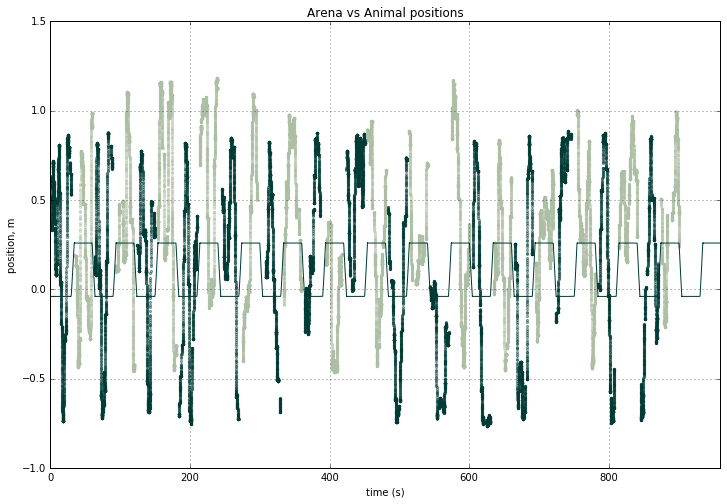

In [14]:
an_traj_A = animal_trajectory[A_indexes]
an_traj_B = animal_trajectory[B_indexes]

fig = arena_vs_animal_positions(arena_trajectory, an_traj_A, an_traj_B)

# All cells firing maps

Processing unit group 7..

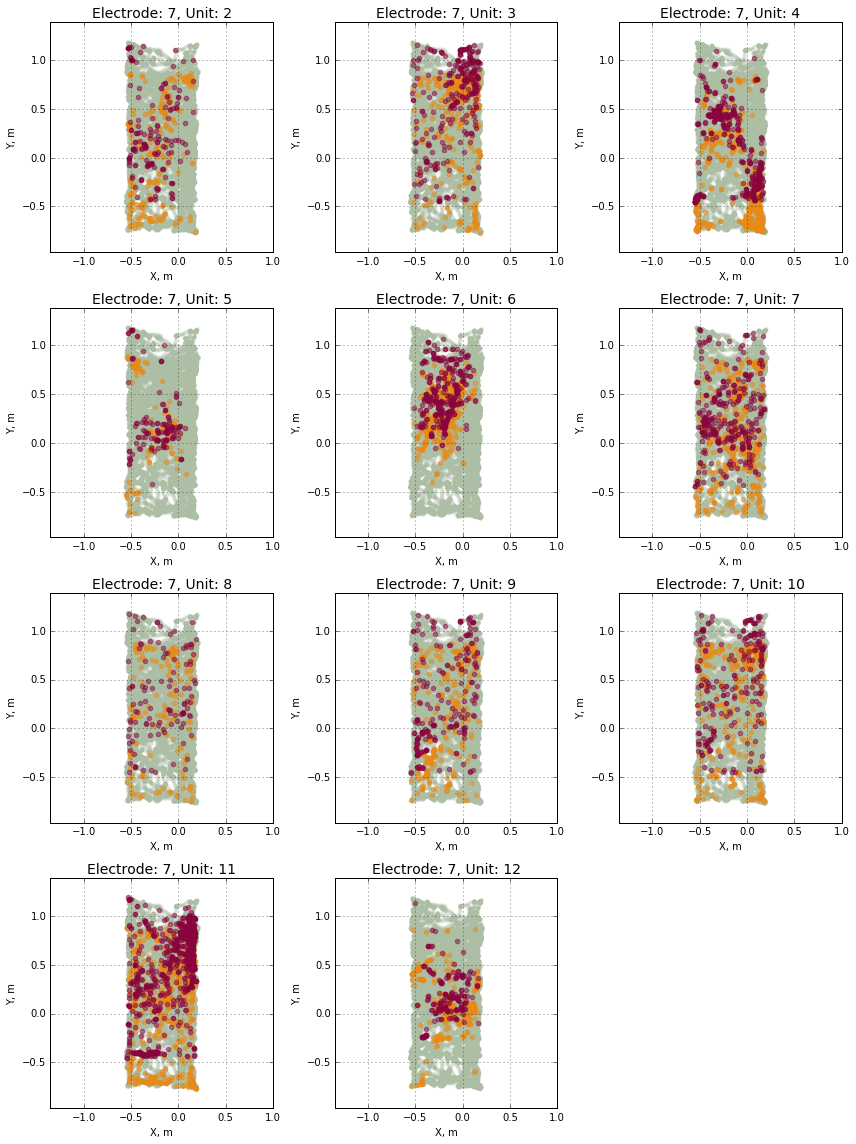

In [15]:
fig = all_AB_cells(session, A_indexes, B_indexes)

#filename = "all_units.png"
#fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

### Assign a session metadata matrix

In [16]:
# for each column: pshift, vshift, gain, dark, periodic

meta_conditions = {
    'SHIFT both': 'A, B',
    'SHIFT both +dark': 'A, B, Ad, Bd',
    'SHIFT periodic': 'A, B',
    'SHIFT periodic +dark': 'A, B, Ad, Bd',
    'SHIFT single': 'A, B',
    'SHIFT single +dark': 'A, B, Ad, Bd',
    'SHIFT visual': 'A, B',
    'SHIFT visual +dark': 'A, B, D',
    'SHIFT visual long +dark': 'A, B, D',
    'GAIN 3 parts 1.2x': 'A, B, C, D',
    'GAIN 3 parts 1.4x': 'A, B, C, D',
}


meta_matrices = {
    'SHIFT both': ((0, 0, 1, 0, 1), (0.3, 0.3, 1, 0, 1)),
    'SHIFT both +dark': ((0, 0, 1, 0, 1), (0.3, 0.3, 1, 0, 1), (0, 0, 1, 1, 1), (0.3, 0, 1, 1, 1)),
    'SHIFT periodic': ((0, 0, 1, 0, 1), (0.3, 0, 1, 0, 1)),
    'SHIFT periodic +dark': ((0, 0, 1, 0, 1), (0.3, 0, 1, 0, 1), (0, 0, 1, 1, 1), (0.3, 0, 1, 1, 1)),
    'SHIFT single': ((0, 0, 1, 0, 0), (0.3, 0, 1, 0, 0)),
    'SHIFT single +dark': ((0, 0, 1, 0, 0), (0.3, 0, 1, 0, 0), (0, 0, 1, 1, 0), (0.3, 0, 1, 1, 0)),
    'SHIFT visual': ((0, 0, 1, 0, 1), (0, 0.3, 1, 0, 1)),
    'SHIFT visual +dark': ((0, 0, 1, 0, 1), (0, 0.3, 1, 0, 1), (0, 0, 1, 1, 0)),
    'SHIFT visual long +dark': ((0, 0, 1, 0, 1), (0, 0.6, 1, 0, 1), (0, 0, 1, 1, 0)),
    'GAIN 3 parts 1.2x': ((0, 0, 1, 0, 0), (0, 0, 1.2, 0, 0), (0, 0.3, 1, 0, 0), (0, 0, 1, 1, 0)),
    'GAIN 3 parts 1.4x': ((0, 0, 1, 0, 0), (0, 0, 1.4, 0, 0), (0, 0.6, 1, 0, 0), (0, 0, 1, 1, 0)),
}


In [31]:
source = '/home/andrey/storage2/andrey/data/processed'
animals = ['00908', '00910', '002784', '003281', '003282']
#animals = ['003908', '003909', '005363', '005364']

In [33]:
for animal in animals:
    animal_path = os.path.join(source, animal)
    sessions_list = [x for x in os.listdir(animal_path) if os.path.isdir(os.path.join(animal_path, x))]

    #sessions_list = ['2020-03-28_18-06-58']
    
    print("Animal %s, TOTAL %s sessions" % (animal, len(sessions_list)))

    for session in sessions_list:
        try:
            datetime.strptime(session, "%Y-%m-%d_%H-%M-%S")
        except ValueError:
            continue  # skip non-session folders

        path = os.path.join(source, animal, session)
        h5_files = [x for x in os.listdir(path) if 'all.h5' in x]

        if len(h5_files) == 0:
            continue  # skip no HDF5 files
            
        h5path = os.path.join(path, h5_files[0])
        exp_type = derive_session_type(path)
        
        if not exp_type in meta_conditions.keys():
            continue
        
        metadata = np.array(meta_matrices[exp_type])
        meta_row_description = meta_conditions[exp_type]
        meta_col_description = 'pshift, vshift, gain, dark, periodic'
        
        with h5py.File(h5path, 'a') as f:
            if 'metadata' in f:
                del f['metadata']
                
            f.create_dataset('metadata', data=metadata)
            f['metadata'].attrs['row_description'] = meta_row_description
            f['metadata'].attrs['col_description'] = meta_col_description

Animal 00908, TOTAL 33 sessions
Animal 00910, TOTAL 41 sessions
Animal 002784, TOTAL 2 sessions
Animal 003281, TOTAL 66 sessions
Animal 003282, TOTAL 84 sessions
